# Neural Networks and Deep Learning

## Homework 1 - Regression task

### Academic Year 2021/2022 
### Dr. Alberto Testolin, Dr. Umberto Michieli

### Capettini Croatto Hilario



## General overview
In this notebook implemented and tested simple neural network models for solving supervised problems. 

* **Regression task**: 
the regression model will consist in a simple function approximation problem, similar to the one discussed during the Lab practices. 


In this case I explored the use of advanced optimizers and regularization methods (e.g., initialization scheme, momentum, ADAM, early stopping, L2, L1 / sparsity, dropout…) to improve convergence of stochastic gradient descent and promote generalization. Learning hyperparameters were tuned using a grid search, and final accuracy was evaluated using a cross-validation setup.


# Regression task

* The goal is to train a neural network to approximate an unknown function:
$$ 
f:\mathbb{R}→\mathbb{R} \\
x↦y=f(x) \\
\text{network}(x) \approx f(x)
$$
* As training point, you only have noisy measures from the target function.
$$
\hat{y} = f(x) + noise
$$
* Consider to create a validation set from you training data, or use a k-fold cross-validation strategy. You may find useful these functions from the `scikit-learn` library:
    - [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
    - [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold) 

In [1]:
#---------------
#IMPORTS
#---------------
### Python basics
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

### Torch library
import torch
from torch import nn
import torch.optim as optim

import pytorch_lightning as pl

### Skorch
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV


C:\Users\hilar\anaconda3\envs\NNDL_torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
### Set seeds for reproducibility (PyTorch, Python, Numpy)
matricola = 2013031
torch.manual_seed(matricola)
random.seed(matricola)
np.random.seed(matricola)


In [61]:
### Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")


Training device: cpu


### Data preview

In [62]:
df_train = pd.read_csv('regression_dataset/train_data.csv',names=["x","y"])
df_test  = pd.read_csv('regression_dataset/test_data.csv',names=["x","y"])

print("# of samples for training", len(df_train))
print("# of samples for testing", len(df_test))

# of samples for training 100
# of samples for testing 100


In [63]:
### detect nan objects
df_train.isna().sum()

x    0
y    0
dtype: int64

In [64]:
df_train.head()

,x,y
0,-4.787870,-1.216804
1,-3.509057,3.277581
2,-3.855373,2.621375
3,-4.083518,1.046088
4,-4.230588,1.228874


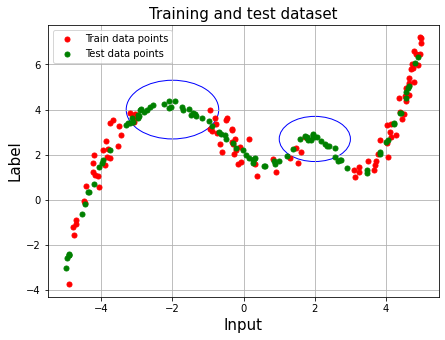

In [65]:
circle1 = plt.Circle((2, 2.7), 1, color='b', fill=False)
circle2 = plt.Circle((-2, 4), 1.3, color='b', fill=False)

#Lets see our dataset
fig = plt.figure(figsize=(7,5))
plt.plot(df_train.x,df_train.y, color='r', ls='', marker='.',ms=10, label='Train data points')
plt.plot(df_test.x,df_test.y, color='g', ls='', marker='.',ms=10, label='Test data points')
plt.gca().add_patch(circle1)
plt.gca().add_patch(circle2)
plt.xlabel("Input",fontsize=15)
plt.ylabel("Label",fontsize=15)
plt.title("Training and test dataset",fontsize=15)
plt.legend()
plt.grid()
plt.savefig('./imgs/regression/dataset.svg', format='svg')
plt.show()

Observe the absence of training points in the two local maximums (at -2 and at 2). This will cause some problems in our model since we have to capture it even though we do not have points for training. This has to be overcome getting a network with a big ability for generalizing.

**Pre-process the data**
We implement a basic pre processing of the data to attempt a faster convergence of the network. We go for feature standardization.


In [66]:
### Extract data from datasets
# As the dataset is really small i wont use pytorch datasets classes here
x_train = np.array(df_train.x)
y_train = np.array(df_train.y)
x_train=np.expand_dims(x_train, axis=1)
y_train=np.expand_dims(y_train, axis=1)


### feature standarization of the data
x_train = (x_train - x_train.mean())/x_train.std()
y_train = (y_train - y_train.mean())/y_train.std()


### Convert to pytorch tensors 
x_train=torch.from_numpy(x_train).float()
y_train=torch.from_numpy(y_train).float()

### Model

In [25]:
class regressionNN(pl.LightningModule):
    
    def __init__(self, Nh1, Nh2, d1, d2,activation = nn.ReLU(),prints=False):
        """
        This function initialize the networks architecture given the parameters
        
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        d1  - drop percent for hidden layer 1
        d2  - drop percent for hidden layer 2
        """
        super().__init__()
        if prints: print("Network initialized")
        
        self.net = nn.Sequential(nn.Linear(in_features  = 1,
                                           out_features = Nh1),
                                 activation,
                                 nn.Dropout(p=d1),
                                 nn.Linear(in_features  = Nh1,
                                           out_features = Nh2),
                                 activation,
                                 nn.Dropout(p=d2),
                                 nn.Linear(in_features  = Nh2,
                                           out_features = 1))
        
        ### initialize variables to store the losses for tensorboard
        self.val_loss = []
        self.train_loss = []
        
    # Forward step defines how the LightningModule behaves during inference/prediction.
    def forward(self, x, additional_out=False):
        return self.net(x)
    

### Hyperparameters optimization using Skorch 

For the regression task I go for the traditional gridsearch method given that the NN to use are small and therefore it is relatively fast to train them. Also because the trainig set is quiete small (a maximum of 100 points).

In [8]:
### Extract data from datasets
# As the dataset is really small i wont use pytorch datasets classes here
x_train = np.array(df_train.x)
y_train = np.array(df_train.y)

### Convert to pytorch tensors of the right dimension
x_train=np.expand_dims(x_train, axis=1)
y_train=np.expand_dims(y_train, axis=1)
x_train=torch.from_numpy(x_train).float()
y_train=torch.from_numpy(y_train).float()


As I will be searching over a huge ammount of models (combination of different hyperparameters given a fixed architecture) I think it could be usefull to use the [early stop](https://skorch.readthedocs.io/en/stable/callbacks.html) from Skorch to avoid further training a model if the validation loss is not showing further improvements.

I define the network using the [NeuralNetRegressor](https://skorch.readthedocs.io/en/stable/regressor.html) subclass of Skorch in order to profit from the [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). In parcicular I use this class from Sklearn because allow me to perform a cross validation. In this case I do it because our training set is already very small (100 samples) so keeping a validation set appart could prive us from usefull data for the training.

The cross validation is performed using 5 folds and a maximum of 1000 epochs.

In [9]:
#Parameters
kf = 5                #Number of folds for the cross validation
maximum_epochs = 1000 #Maximum number of epochs

#Define early stopping capabilities
early_stop = EarlyStopping(monitor='valid_loss',
                           lower_is_better = True,
                           patience=100,
                           threshold=1e-3,
                           threshold_mode='rel'
                           )

#Network definition using skorch for the sklearn gridsearch
net_skorch = NeuralNetRegressor(module = regressionNN,               #Our NN model followed by the model parameters
                                module__Nh1 = 50,
                                module__Nh2 = 50,
                                module__d1 = 0.,
                                module__d2 = 0.,
                                optimizer = optim.SGD,               #The model optimizer 
                                optimizer__lr = 1e-4,                #Optimizer learning rate 
                                optimizer__weight_decay = 0.,        #Optimizer seight decay for L2 regularization
                                max_epochs=maximum_epochs,           
                                criterion =nn.MSELoss,               #Loss function to be used 
                                callbacks = [early_stop],            #Check of the validation loss for the early stop
                                verbose=1
                                )

#Define the dictionary for the gridsearch
#The search space grows very fast so I only try critical parameters
params = {"module__Nh1":[25,50,75,100],
          "module__Nh2":[25,50,75,100],
          "module__d1": [0,0.01,0.1],
          "module__d2": [0,0.01,0.1],
          "optimizer":[optim.Adam],    #SGD is not worth trying 
          "optimizer__lr":[1e-3,1e-2],
          "optimizer__weight_decay":[1e-3,1e-4,1e-5]
          }

#Define the gridsearch
gs = GridSearchCV(net_skorch,
                  params,
                  refit=True,
                  cv=kf,
                  n_jobs = 2,
                  scoring='neg_mean_squared_error',
                  verbose=1)


In [10]:
#Perform the grid search
gs.fit(x_train, y_train)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       12.4027        7.9724  0.0398
      2        5.6031       14.9950  0.0067
      3        2.7744       14.9292  0.0073
      4        3.4699        9.1443  0.0058
      5        4.0695        5.2354  0.0045
      6        3.2248        4.1430  0.0052
      7        2.5500        3.9442  0.0055
      8        2.0085        3.8673  0.0050
      9        2.0595        3.7850  0.0072
     10        2.3352        3.9859  0.0065
     11        2.0640        4.8586  0.0057
     12        2.0749        6.3734  0.0058
     13        1.8492        7.8103  0.0068
     14        1.8541        7.4122  0.0065
     15        1.6831        5.8880  0.0068
     16        1.7929        4.3882  0.0056
     17        1.8092        3.5617  0.0052
     18        1.7378        3.2610  0.0053
     19        1.6210        3.2694  0.0051
     20     

    161        0.2485        0.6021  0.0086
    162        0.2955        0.6056  0.0065
    163        0.2347        0.6056  0.0073
    164        0.3073        0.5907  0.0067
    165        0.2819        0.5845  0.0083
    166        0.2924        0.6143  0.0087
    167        0.2724        0.5774  0.0068
    168        0.2894        0.5790  0.0080
    169        0.3125        0.5980  0.0083
    170        0.3031        0.6032  0.0080
    171        0.2536        0.6900  0.0087
    172        0.3241        0.6258  0.0056
    173        0.3566        0.6699  0.0081
    174        0.3049        0.6346  0.0050
    175        0.2968        0.6658  0.0070
    176        0.2459        0.6618  0.0070
    177        0.3366        0.6387  0.0090
    178        0.1948        0.6762  0.0071
    179        0.2983        0.6041  0.0070
    180        0.2636        0.7403  0.0070
    181        0.3724        0.7001  0.0070
    182        0.2850        0.6770  0.0070
    183        0.3198        0.8

GridSearchCV(cv=5,
             estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class '__main__.regressionNN'>,
  module__Nh1=50,
  module__Nh2=50,
  module__d1=0.0,
  module__d2=0.0,
),
             n_jobs=2,
             param_grid={'module__Nh1': [25, 50, 75, 100],
                         'module__Nh2': [25, 50, 75, 100],
                         'module__d1': [0, 0.01, 0.1],
                         'module__d2': [0, 0.01, 0.1],
                         'optimizer': [<class 'torch.optim.adam.Adam'>],
                         'optimizer__lr': [0.001, 0.01],
                         'optimizer__weight_decay': [0.001, 0.0001, 1e-05]},
             scoring='neg_mean_squared_error', verbose=1)

In [11]:
#print the best model
print("The best score was",gs.best_score_)
print("")
print("It was obtained using the following parameters:", gs.best_params_)

The best score was -4.627454274892807

It was obtained using the following parameters: {'module__Nh1': 75, 'module__Nh2': 75, 'module__d1': 0, 'module__d2': 0.1, 'optimizer': <class 'torch.optim.adam.Adam'>, 'optimizer__lr': 0.01, 'optimizer__weight_decay': 1e-05}


According to the documentation if now we fit the best model we will be performing a cross validation with the number of folds defined in the grid search.

In [12]:
#Lets retrieve the best model
best_nn = gs.best_estimator_

#Lets fit this in the training data
best_nn.fit(x_train, y_train)


Re-initializing module because the following parameters were re-set: Nh1, Nh2, d1, d2.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       12.9608        4.7460  0.0062
      2        4.4861       10.7990  0.0060
      3        2.8128       13.5730  0.0056
      4        4.5563       10.4686  0.0047
      5        3.9083        7.2883  0.0049
      6        2.9123        5.2829  0.0049
      7        2.3989        4.4178  0.0060
      8        2.4964        4.1390  0.0060
      9        2.4654        4.0854  0.0050
     10        2.5203        4.1917  0.0063
     11        2.3515        4.5761  0.0056
     12        1.9789        5.2387  0.0060
     13        1.8244        5.6634  0.0055
     14        2.0982        5.2897  0.0070
     15        1.7207        4.4305  0.0063
     16        1.9096        3.5290  0.0060
     17        1.7367        3.0810  0.0070
     18        1.5667  

    162        0.3146        0.5772  0.0080
    163        0.3399        0.5864  0.0090
    164        0.3747        0.5925  0.0080
    165        0.3437        0.5784  0.0080
    166        0.3711        0.5677  0.0110
    167        0.3868        0.5703  0.0090
    168        0.2846        0.5914  0.0090
    169        0.3950        0.6111  0.0070
    170        0.2677        0.5710  0.0081
    171        0.3504        0.5752  0.0089
    172        0.3470        0.5659  0.0073
    173        0.3486        0.5636  0.0093
    174        0.3491        0.5694  0.0100
    175        0.3618        0.5649  0.0090
    176        0.2708        0.5583  0.0080
    177        0.3067        0.5546  0.0086
    178        0.3564        0.5889  0.0100
    179        0.4557        0.6170  0.0080
    180        0.3223        0.5589  0.0075
    181        0.3466        0.5326  0.0070
    182        0.2759        0.5317  0.0098
    183        0.2942        0.5375  0.0109
    184        0.2733        0.5

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=regressionNN(
    (net): Sequential(
      (0): Linear(in_features=1, out_features=75, bias=True)
      (1): ReLU()
      (2): Dropout(p=0, inplace=False)
      (3): Linear(in_features=75, out_features=75, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.1, inplace=False)
      (6): Linear(in_features=75, out_features=1, bias=True)
    )
  ),
)

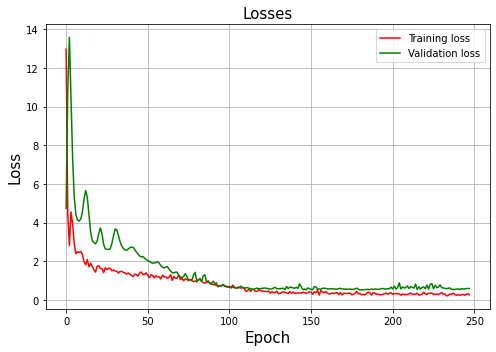

In [13]:
#Lets see the losses evolution
training_loss   = best_nn.history[:,"train_loss"]
validation_loss = best_nn.history[:,"valid_loss"]

#Plot the losses of the best model
plt.figure(figsize=(7,5))
plt.plot(training_loss, color='r' , label='Training loss')
plt.plot(validation_loss, color='g', label='Validation loss')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.title("Losses",fontsize=15)
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('./imgs/regression/losses.svg', format='svg')
plt.show()

#### Performance over the test set

In [14]:
#Extract data from datasets
x_test = np.array(df_test.x)
y_test = np.array(df_test.y)

#Convert to pytorch tensors of the right dimension
x_test=np.expand_dims(x_test, axis=1)
y_test=np.expand_dims(y_test, axis=1)
x_test=torch.from_numpy(x_test).float()
y_test=torch.from_numpy(y_test).float()

In [15]:
#Predict on the test set
y_pred = best_nn.predict(x_test)

#As the test is mixed we order it to plot a solid line
x_pred,y_pred = zip(*sorted(zip(x_test.numpy(),y_pred)))

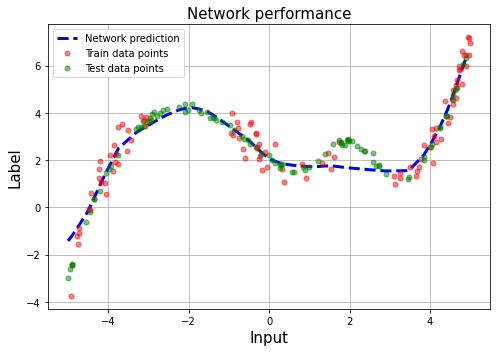

In [16]:
### Plot
fig = plt.figure(figsize=(7,5))
plt.plot(x_pred,y_pred, color='b', ls='--',lw=3, label='Network prediction')
plt.plot(x_train,y_train, color='r', ls='', marker='.',ms=10,alpha=0.5, label='Train data points')
plt.plot(x_test,y_test, color='g', ls='', marker='.',ms=10,alpha=0.5, label='Test data points')
plt.xlabel('Input',fontsize=15)
plt.ylabel('Label',fontsize=15)
plt.title("Network performance",fontsize=15)
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('./imgs/regression/fit.svg', format='svg')
plt.show()

### Network analysis

In [17]:
nn_layers = best_nn.module_#.net

In [18]:
nn_layers

regressionNN(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=75, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=75, out_features=75, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=75, out_features=1, bias=True)
  )
)

In [19]:
# First hidden layer
h1_w = nn_layers.net[0].weight.data.cpu().numpy()
h1_b = nn_layers.net[0].bias.data.cpu().numpy()

# Second hidden layer
h2_w = nn_layers.net[3].weight.data.cpu().numpy()
h2_b = nn_layers.net[3].bias.data.cpu().numpy()

# Output layer
out_w = nn_layers.net[6].weight.data.cpu().numpy()
out_b = nn_layers.net[6].bias.data.cpu().numpy()

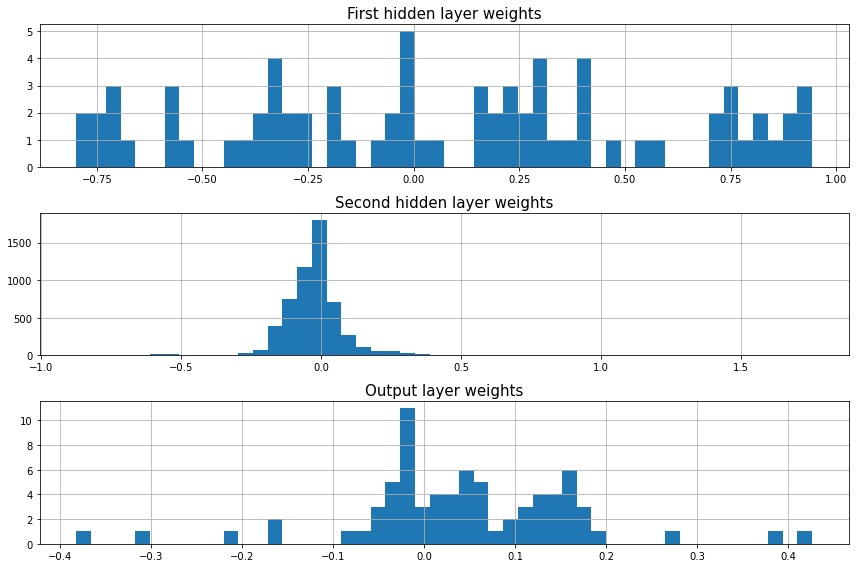

In [20]:
# Weights histogram
fig, axs = plt.subplots(3, 1, figsize=(12,8))
axs[0].hist(h1_w.flatten(), 50)
axs[0].set_title('First hidden layer weights',fontsize=15)
axs[1].hist(h2_w.flatten(), 50)
axs[1].set_title('Second hidden layer weights',fontsize=15)
axs[2].hist(out_w.flatten(), 50)
axs[2].set_title('Output layer weights',fontsize=15)
[ax.grid() for ax in axs]
plt.tight_layout()
plt.savefig('./imgs/regression/wh.svg', format='svg')
plt.show()

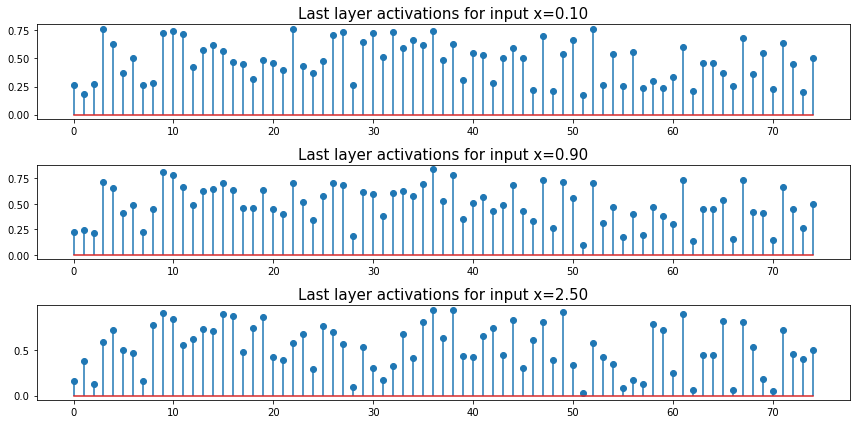

In [21]:
#analize activataion
def get_activation(layer, input, output):
    global activation
    activation = torch.sigmoid(output)

### Register hook  
hook_handle = nn_layers.net[0].register_forward_hook(get_activation)

### Analyze activations
nn_layers = nn_layers.to(device)
nn_layers.eval()
with torch.no_grad():
    x1 = torch.tensor([0.1]).float().to(device)
    y1 = nn_layers(x1)
    z1 = activation
    x2 = torch.tensor([0.9]).float().to(device)
    y2 = nn_layers(x2)
    z2 = activation
    x3 = torch.tensor([2.5]).float().to(device)
    y3 = nn_layers(x3)
    z3 = activation

### Remove hook
hook_handle.remove()

### Plot activations
fig, axs = plt.subplots(3, 1, figsize=(12,6))
axs[0].stem(z1.cpu().numpy(), use_line_collection=True)
axs[0].set_title('Last layer activations for input x=%.2f' % x1,fontsize=15)
axs[1].stem(z2.cpu().numpy(), use_line_collection=True)
axs[1].set_title('Last layer activations for input x=%.2f' % x2,fontsize=15)
axs[2].stem(z3.cpu().numpy(), use_line_collection=True)
axs[2].set_title('Last layer activations for input x=%.2f' % x3,fontsize=15)
plt.tight_layout()
plt.savefig('./imgs/regression/activations.svg', format='svg')
plt.show()